# Bernstein–Vazirani Algorithm
<hr></hr>

The [Bernstein-Vazirani algorithm](https://en.wikipedia.org/wiki/Bernstein–Vazirani_algorithm), introduced by Ethan Bernstein and [Umesh Vazirani](https://en.wikipedia.org/wiki/Umesh_Vazirani) in 1997 [[Bernstein97]](https://dl.acm.org/doi/pdf/10.1145/167088.167097), is a quantum algorithm that, in a single try, solves the Bernstein-Vazirani problem, which entails finding a secret binary string $s$. In contrast, a classical approach requieres up to $n$ tries, where $n$ is the length of the secret string.

The steps of the Bernstein-Vazirani algorithm are identical to those used in the Deutsch-Jozsa algorithm. The difference between the two is in the "black box" $U_f$, which instead of being either a balanced or constant $f(x)$, it encodes a function that depends on both the input $x$ and the string $s.$

Concretely, we are given a function of the form $f(x) = s \cdot x$, where $x$ and $s$ are $n$-bit binary numbers, and the symbol $\text{"} \cdot \text{"}$ represents the binary dot product:

$$ s \cdot x = \bigoplus_{i=0}^{n-1} s_{i} x_{i} = s_{0} x_{0} \oplus s_{1} x_{1} \oplus \dots \oplus s_{n-1} x_{n-1} .$$

In other words, we take the bitwise **AND** (product) between each bit of $s$ and $x$, and perform an **XOR** (addition modulo-2) to get a single output bit $f(x)$.

Let's use python to generate each output $f(x)$ for every possible value of $x$ given a string $s$:

In [1]:
import numpy as np

In [2]:
s = '1101'          # String
n = len(s)
s_int = int(s, 2)

print(f'Outcomes for s = {s}\n')
print('x',' '*(n), 'f(x)')

for x_int in range(2**n):    
    x = np.binary_repr(x_int,n)
    fx = sum(int(si,2) & int(xi,2) for si, xi in zip(s, x)) % 2
    
    if x_int == 0 or (x_int & (x_int - 1)):
        print(x, ' ', fx)
    else:
        print(x, ' ', fx, '←')

Outcomes for s = 1101

x      f(x)
0000   0
0001   1 ←
0010   0 ←
0011   1
0100   1 ←
0101   0
0110   1
0111   0
1000   1 ←
1001   0
1010   1
1011   0
1100   0
1101   1
1110   0
1111   1


## 1.1 Classical Approach

An interesting observation from the list above is that, whenever we have an input $x$ where only one of its bits $x_i$ is equal to $1$ (elements marked with $\leftarrow$), we get an output $f(x)$ equal to $0$ if the string $s$ has the corresponding bit $s_i$ equal to 0, and an output $f(x)$ equal to $1$ if $s_i = 1$.

So, to extract the string $s$ from the function $f(x)$, we can pass each of the following $n$ possible inputs through $f(x)$: 

$$
\begin{aligned}
x =&\, 0 \dots 01
\\
x =&\, 0 \dots 10 
\\
&\vdots 
\\
x =&\, 1 \dots 00 ,
\end{aligned}
$$

and use each the output to identify the corresponding bit $s_i$ . In other words, the values of $x$ shown above serve as individual masks that extract each of the bits of $s$.

Let's now create a python function that encodes the function function $f(x) = s \cdot x$ into a unitary black box $U_f$ (details on this implementation are discussed in section 1.3).

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [4]:
# Function that generates Uf, which encodes f(x) = s⋅x for a random sting s of length n
def black_box(n):
    s_int = np.random.randint(2**n)
    s = np.binary_repr(s_int, n)
    controls = [i+1 for i, v in enumerate(reversed(s)) if v == '1']
    
    qc_bb = QuantumCircuit(n+1, name='Black Box')
    if controls:
        qc_bb.cx(controls,[0]*len(controls))
        
    return qc_bb, s

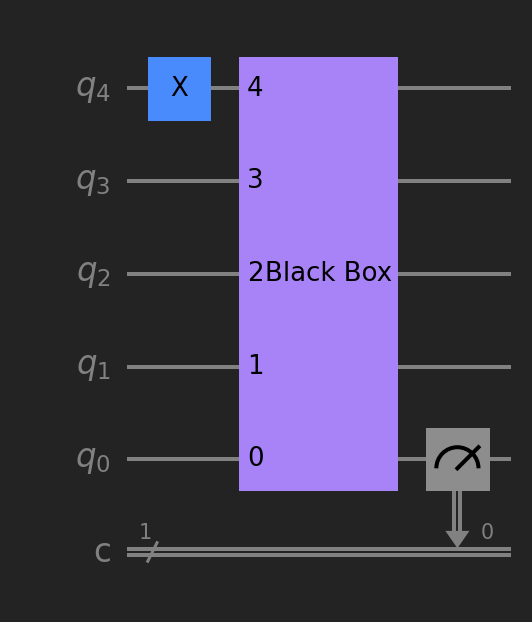

In [5]:
# Draw example circuit to solve B-V's problem classically (n = 4, x = 1000)
n = 4
bb, _ = black_box(n)

qc = QuantumCircuit(n+1,1)
qc.x(n)
qc.append(bb,range(n+1))
qc.measure(0,0)
qc.draw()

If we now iterate over the $n$ inputs for which $x$ has only one of it's bits equal to $1$, we can find the randomly encoded secret string $s$ by checking each of the corresponding $f(x)$ outputs:

In [6]:
n = 3                  # String length
bb, s = black_box(n)   # Generate black box and secret string

s_out = ''             # variable to store string extracted from f(x) classically

simulator = AerSimulator()

for i in range(n):
    
    x_int = 2**i
    x = np.binary_repr(x_int, n)
    input_ones = [i+1 for i, v in enumerate(reversed(x)) if v == '1']
    
    qc = QuantumCircuit(n+1,1)
    qc.x(input_ones)
    qc.append(bb,range(n+1))
    qc.measure(0,0)
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation to get f(x) outcome
    outcome = job.result().get_memory()[0]
    
    s_out = outcome + s_out
    
print(f'secret string: {s}')
print(f'extracted string: {s_out}')

secret string: 100
extracted string: 100


We can then conclude that, with a classical approach, it takes exactly $n$ function evaluations to find the secret string.

### 1.2 Quantum Approach

As mentioned before, the quantum algorithm to solve this problem is identical to the Deutsch-Jozsa algorithm, but where our black box $U_f$ now encodes the function $f(x) = s \cdot x :$

<img src="images/04_01_10_deutsch-jozsa.png" align = "center" width="520"/>

Let's then analyze the circuit step by step to see the difference:

0. Initialize the all-zeros state: $|\psi\rangle_0 = |0\rangle^{\otimes n} \otimes |0\rangle$
1. Apply $X$ gate to bottom qubit $|p\rangle$: $|\psi\rangle_1 = |0\rangle^{\otimes n} \otimes |1\rangle$
2. Apply $H$ gate to $|p\rangle$ and $\text{QHT}$ to $|q\rangle$: $|\psi\rangle_2 = \text{QHT}_n |0\rangle^{\otimes n} \otimes H |1\rangle$

This places the input state $|q\rangle$ in an equal superposition over all possible values of $x$, and $|p\rangle$ in the minus state:

$$
|\psi\rangle_2 = \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \right) \otimes |-\rangle, \; \text{where} \; N = 2^n .
$$

3. Evolve the state through the black box: $|\psi\rangle_3 = U_f |\psi\rangle_2$, which results in:

$$
\begin{aligned}
|\psi\rangle_3 &= \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} (-1)^{f(x)} |x\rangle \right) \otimes |-\rangle
\\
\\
|\psi\rangle_3 &= \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} (-1)^{s \cdot x} |x\rangle \right) \otimes |-\rangle .
\end{aligned}
$$

Now, the term inside the parenthesis is something we have seen before! This is nothing other than the $\text{QHT}$ applied to a basis state $|s\rangle$. We can therefore rewrite $|\psi\rangle_3$ as:

$$ |\psi\rangle_3 = \left( \text{QHT}_n |s\rangle \right) \otimes |-\rangle . $$

4. Lastly, we apply an $H$ gate to the bottom qubit $|p\rangle$, and the $\text{QHT}$ to the top qubits $|q\rangle$: 

$$
\begin{aligned}
|\psi\rangle_4 &= \text{QHT}_n \left( \text{QHT}_n |s\rangle \right) \otimes H |-\rangle .
\\
\\
|\psi\rangle_4 &= |s\rangle \otimes |1\rangle.
\end{aligned}
$$

This means that, if we measure the register $|q\rangle$, we will get the string $s$ with $100 \%$ probability!

Let's run this using Qiskit and show that we only need to evaluate the circuit once to extract the secret string $s.$

In [7]:
def bernstein_vazirani(n):
    bb, s = black_box(n)                      # generate random black-box of n input qubits
    
    qc_bv = QuantumCircuit(n+1,n)
    qc_bv.x(0)                                # Initialize bottom qubit to |1〉
    qc_bv.barrier()
    qc_bv.h(range(n+1))                       # Hadamard gates on all qubits
    qc_bv.append(bb,range(n+1))               # append black box to circuit
    qc_bv.h(range(n+1))                       # Hadamard gates on all qubits
    qc_bv.measure(range(1,n+1),range(n))      # measure top n qubits
    
    return qc_bv, s

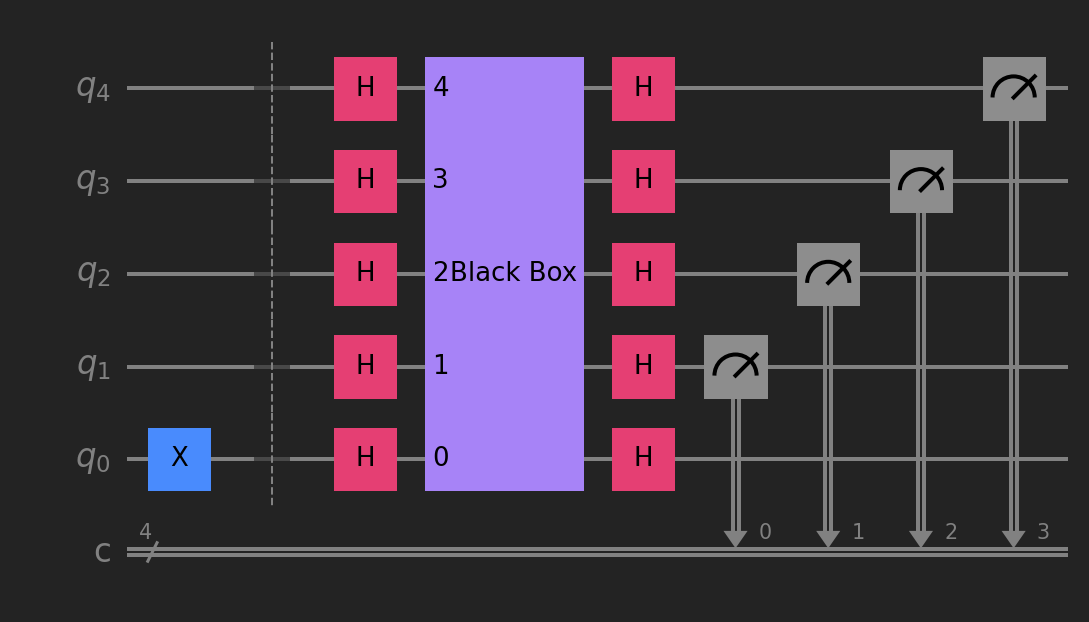

In [8]:
# Draw example of Bernstein-Vazirani circuit for 4 qubits
qc = bernstein_vazirani(4)[0]
qc.draw()

In [9]:
# Simulate circuit once to extract s

n = 4   # Length of string s

qc, s = bernstein_vazirani(n)
qc_t = transpile(qc, simulator)
job = simulator.run(qc_t, shots=1, memory=True)  # Run simulation once
s_out = job.result().get_memory()[0]

print(f'secret string: {s}')
print(f'extracted string: {s_out}')

secret string: 0010
extracted string: 0010


### 1.3 Comments on Black Box Implementation

Implementing the black box that encodes the Bernstein-Vazarini is actually relatively simple. Recall that, in the classical strategy to solve the problem, we used a series of $n$ inputs $x$ where we had only one of their bits $x_i$ equal to $1$, for each $i \in n$. We then said that, if for a given input with $x_i = 1$ the output $f(x) = 1$, then  that meant that the string bit $s_i = 1$. 

So all we need to do to construct the circuit for a given secret string $s$, is to add $CX$ gates with their controls on each qubit $|x_i\rangle$ for which $s_i = 1.$ 

Let's look at an example (re-run:

In [10]:
from qiskit import QuantumRegister

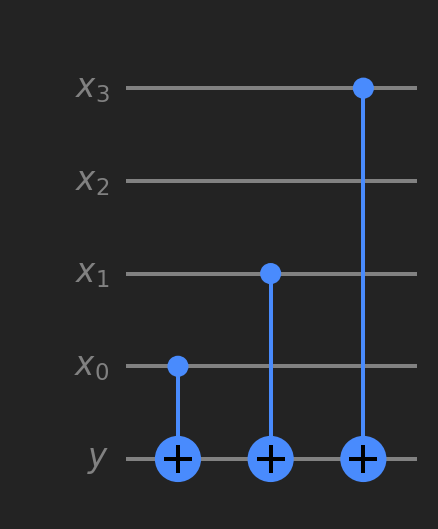

In [11]:
s = '1011'  # Secret string
n = len(s)  # Number of bits

# List of positions i where s_i = 1
controls = [i+1 for i, v in enumerate(reversed(s)) if v == '1']

xr = QuantumRegister(n, name='x')
yr = QuantumRegister(1, name='y')

qc_s = QuantumCircuit(yr,xr)
qc_s.cx(controls,[0]*len(controls)) # Add cx gates

qc_s.draw()

Modify the value of `s` above to see how the circuit changes accordingly.